In [1]:
#!pip install --upgrade oct2py
import numpy as np
import pandas as pd
from oct2py import octave
import matplotlib.pyplot as plt
import os
from scipy.optimize import root
import pickle
octave.addpath('C:/dynare/6.1/matlab') 
from IPython.display import display
#octave.addpath('/opt/homebrew/opt/dynare/lib/dynare/matlab')

    _pyeval at line 57 column 30

    _pyeval at line 57 column 30



`DyPy` is a class that we create and store in a file called `MyPy.py`. It contains methods for 

* converting data from a Dynare stucture to Numpy arrays.
* analyzing the data. 

See the file for details. 

In [2]:
from MyPy_2 import DyPy

Creates a file called `t_call.m`. This informs Dynare of the format we want for output. It is put here so that adjusments can be made easily; for example the number of periods can be changed here rather than by looking at the `.mod` file. It is included in the `.mod` file via: `@#include "t_call.m"` in `model_1.mod`

* `order`: the order of approximation for the stochastic simulation. order=1 is a fsrst-order approximation (linearization) Higher-order approximations (e.g., order=2 for second-order) capture nonlinear effects in the model, but they require more computational resources.
* `periods`: number of periods (time steps) for which the simulation will be run. periods=1000 means that the model will be simulated for 1000 periods. The default value is 0, which means no simulation will be performed.
* `nograph`: suppresses the graphical output of the simulation results in Dynare since we draw them separatetly. 
* `irf`: the number of periods for which the impulse response functions (IRFs) will be computed and plotted. 

In [3]:
with open('t_call.m', 'w') as file:
    file.write("stoch_simul(nograph, order=1, periods=1000, irf=100);")

 `make_model.ipyn` writes a file called `t_model.m`. `t_model.m`is the `model` block in the Dynare `.mod` file. It can instead be created directlty by commenting out the next `%run` line and coding the model. `make_model.ipyn` simplifies model creation when many of the lines are very similar to each other. Then they can be written in for loops. For the model we are currently working with, there is not much advantage to writing the file via `make_model` but I have done so nonetheless. 
 
 The created file is included in the `.mod` file via `@#include "t_model.m"` in `model_1.mod`. 

In [4]:
%run make_model.ipynb

`make_files.ipynb` writes the other Dynare blocks. See that file for details. However, note that in doing so, it solves for the steady state of the model using `root` from `scipy`. If the results below do not indicate success, the `.mod` file may not run correctly. Also, note that though we solve for the steady state here, we do not give Dynare the steady state but rather use these as starting values for their ss solver. I will later code a verification the steady states are the same. 

In [5]:
%run make_files_1.ipynb

eps,tht,alf,bet,om_0,om_1,om_2,delt,psi_n,psi_k,var_a_0,var_a_1,var_a_2,rho_a_0,rho_a_1,rho_a_2
0.5,1,0.3,0.9,0.1,0.4,0.5,0.05,1,1,0.5,0,0,0.95,0.95,0.95


Tells octave where to find the .m file it will run. The file is `call_dynare`. Set to wherever you have this file. 




In [6]:
#a=octave.addpath(os.path.expanduser('C:/Users/blankenw/GitHub/dynare_progs/np_1'))

Makes a call to Octave, which makes a call to Dynare. Then the `.mod` file is run in Dynare. Output from Dynare is displayed as it runs.

In [7]:

# A list of dictionaries representing updates to apply to my_dict:
new_pars = [{'psi_n': 0, 'psi_k': 0}, 
           {'psi_n': 2, 'psi_k': 0}, 
           {'psi_n': 0, 'psi_k': 2}]



# Create an empty dictionary to store your variables
t=[]
with open('mf1.pkl', 'wb') as f:
    pickle.dump((ss_params,model_params,ss_shock), f)


for i, update in enumerate(new_pars):
    model_params.update(update)
    with open('mf1.pkl', 'wb') as f:
        pickle.dump((ss_params,model_params,ss_shock), f)
    %run make_files_2.ipynb
    with open('mf2.pkl', 'rb') as f:
        ss_dict = pickle.load(f)
    # Set up Octave session and run your model
    octave.dynare('model_1.mod')

    # Pull necessary structures
    oo = octave.pull('oo_')
    Mthing = octave.pull('M_')
    instance = DyPy(oo,ss_dict)
    if i==0:
        oo_0=oo
    t.append(instance)


 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00  0.000e+00  4.703e-10 -8.006e-10 -5.227e-10
            2.621e-10  7.334e-11 -4.796e-14  8.780e-11 -1.483e-10
            7.470e-11]
       x: [ 2.663e-01  3.464e-01  3.873e-01  2.663e-01  3.464e-01
            3.873e-01  2.431e+00  2.261e-01  4.522e-01  5.055e-01
            1.215e-01]
    nfev: 31
    fjac: [[-6.030e-01  4.435e-10 ... -4.625e-03 -9.956e-03]
           [ 5.421e-01  3.263e-10 ... -2.054e-01 -4.370e-03]
           ...
           [ 1.840e-01  5.296e-02 ...  3.938e-01  9.735e-02]
           [-2.977e-01  1.807e-01 ... -2.497e-01 -2.244e-01]]
       r: [-1.658e+00  1.458e+00 ... -5.882e-01 -4.813e-01]
     qtf: [-2.801e-09 -3.286e-09  2.182e-09  9.852e-10  2.222e-09
           -1.184e-09 -2.511e-10 -1.565e-10  5.489e-09  2.437e-09
            5.047e-10]
Starting Dynare (version 6.1).
Calling Dynare with arguments: none
Starting preprocessing of the model file ...
Found 14 equation(s).
Evaluat

Dynare creates a `structure` which we will need so we `pull` it.

The output from Dynare is stored in a file called `oo_`. This brings `oo_` in as `oo`.

Draw all impulse response functions. 

In [8]:
def plot_dta(instances, attributes,periods=100):
    plt.figure(figsize=(15, 5))
    for j, attribute in enumerate(attributes):
        # Create a subplot for this attribute
        plt.subplot(1, len(attributes), j+1)
        for i, instance in enumerate(instances):
            # Get the attribute value (time series data)
            attr_value = getattr(instance.ir_level, attribute)
            attr_value = attr_value.reshape(-1, 1)
            length = attr_value.shape[0]
            tm = np.linspace(1, length, length)
            # Add a line to the plot for this time series
            plt.plot(tm[0:periods], attr_value[0:periods], label=labels[i])

        plt.title(attribute)
        plt.legend()

    # Show the figure with all subplots


In [9]:
labels = ['No adjustment cost', 'Adjustment cost on labor', 'Adjustment cost on capital']

all_attributes =[   #['y_a_0', 'y_a_1', 'y_a_2'],
                    #['y_0_a_0', 'y_0_a_1', 'y_0_a_2'],
                    #['r_a_0', 'r_a_1', 'r_a_2'],
                    #['tot_a_0', 'tot_a_1', 'tot_a_2'],
                    #['sc_a_0', 'sc_a_1', 'sc_a_2'],
                    #['win_a_0', 'win_a_1', 'win_a_2'],
                    #['k_0_a_0', 'k_1_a_0', 'k_2_a_0'],
                    #['n_0_a_0', 'n_1_a_0', 'n_2_a_0'],
                    #['n_0_a_1', 'n_1_a_1', 'n_2_a_1'],
                    #['s_0_a_0', 's_1_a_0', 's_2_a_0'],
                    #['k_a_0', 'i_a_0'],
                    #['k_0_a_1', 'k_1_a_1', 'k_2_a_1'],
                    #['c_0_a_1', 'c_1_a_1', 'c_2_a_1'],
                    #['k_a_1', 'i_a_1'],
                    #['k_0_a_2', 'k_1_a_2', 'k_2_a_2'],
                    #['c_0_a_2', 'c_1_a_2', 'c_2_a_2'],
                    #['k_a_2', 'i_a_2'],
                    #['ns0_a0', 'ns1_a0', 'ns2_a0'],
                    #['ns0_a1', 'ns1_a1', 'ns2_a1'],
                   # ['kn0_a1', 'kn1_a1', 'kn2_a1'],
                    #['ex_0_a_0','ex_1_a_0','ex_2_a_0'],
                    #['exb_0_a_0','exb_1_a_0','exb_2_a_0']
                    
                     ]
for attributes in all_attributes:
    plot_dta(t, attributes,periods=10)
    plt.tight_layout()
    plt.show()                  



In [10]:
j=0
n_0=np.insert(t[j].ir_level.n_0_a_0,0,np.exp(t[j].steady_state[0]))
n_1=np.insert(t[j].ir_level.n_1_a_0,0,np.exp(t[j].steady_state[1]))
n_2=np.insert(t[j].ir_level.n_2_a_0,0,np.exp(t[j].steady_state[2]))
s_0=np.insert(t[j].ir_level.s_0_a_0,0,np.exp(t[j].steady_state[3]))
s_1=np.insert(t[j].ir_level.s_1_a_0,0,np.exp(t[j].steady_state[4]))
s_2=np.insert(t[j].ir_level.s_2_a_0,0,np.exp(t[j].steady_state[5]))
k=  np.insert(t[j].ir_level.k_a_0,0,np.exp(t[j].steady_state[6]))
c_0=np.insert(t[j].ir_level.c_0_a_0,0,np.exp(t[j].steady_state[7]))
c_1=np.insert(t[j].ir_level.c_1_a_0,0,np.exp(t[j].steady_state[8]))
c_2=np.insert(t[j].ir_level.c_2_a_0,0,np.exp(t[j].steady_state[9]))
i=  np.insert(t[j].ir_level.i_a_0,0,(t[j].steady_state[10]))
a_0=np.insert(t[j].ir_level.a_0_a_0,0,np.exp(t[j].steady_state[11]))
a_1=np.insert(t[j].ir_level.a_1_a_0,0,np.exp(t[j].steady_state[12]))
a_2=np.insert(t[j].ir_level.a_2_a_0,0,np.exp(t[j].steady_state[13]))

In [11]:
np.exp(t[j].steady_state[0])

array([0.26630528])

NOTE: need to give more thought to how i calculated. Look at MyPy_2

In [12]:
im=np.log(t[j].ir_level.i_a_0)
i=np.insert(im,0,t[j].steady_state[10])
#np.insert(t[j].ir_level.i_a_0,0,(t[j].steady_state[10]))
#i

In [13]:
s_1+s_2+s_0

array([1.        , 1.08629914, 1.04732191, 1.02462778, 1.01177409,
       1.00486054, 1.00149245, 1.00018944, 1.00003669, 1.00047355,
       1.00116255, 1.00190701, 1.00259857, 1.00318364, 1.00364178,
       1.00397199, 1.00418388, 1.00429225, 1.00431373, 1.00426482,
       1.0041608 , 1.0040152 , 1.00383965, 1.00364387, 1.00343582,
       1.00322186, 1.00300701, 1.0027951 , 1.00258901, 1.0023908 ,
       1.0022019 , 1.00202321, 1.00185524, 1.00169818, 1.00155197,
       1.00141639, 1.00129107, 1.00117557, 1.00106938, 1.00097195,
       1.00088274, 1.00080119, 1.00072673, 1.00065885, 1.00059703,
       1.00054079, 1.00048966, 1.00044322, 1.00040107, 1.00036282,
       1.00032815, 1.00029673, 1.00026827, 1.00024249, 1.00021916,
       1.00019805, 1.00017895, 1.00016167, 1.00014605, 1.00013193,
       1.00011916, 1.00010762, 1.00009719, 1.00008777, 1.00007925,
       1.00007156, 1.00006461, 1.00005834, 1.00005267, 1.00004755,
       1.00004293, 1.00003876, 1.00003499, 1.00003158, 1.00002

In [14]:
#n_0

In [15]:
print(max(n_0))
print(max(n_1))
print(max(n_2))
print(min(n_0))
print(min(n_1))
print(min(n_2))

print(max(s_0))
print(max(s_1))
print(max(s_2))
print(min(s_0))
print(min(s_1))
print(min(s_2))


0.5044392391856206
0.3666743477843253
0.4099543838577419
0.22768500331654623
0.2747169821053024
0.3071429232943752
0.5044392391798391
0.36667434842650004
0.40995438322157685
0.22768500331050304
0.27471698243481896
0.3071429229717752


In [16]:
om_0=model_params['om_0']
om_1=model_params['om_1']
om_2=model_params['om_2']
eps=model_params['eps']

In [17]:
p_0=om_0/om_0*(c_0/c_0)**(-1/eps)
p_1=om_1/om_0*(c_1/c_0)**(-1/eps)
p_2=om_2/om_0*(c_2/c_0)**(-1/eps)
y_0=p_0*(c_0+i)
py_0=p_0*y_0
py_1=p_1*c_1
py_2=p_2*c_2


y=py_0+py_1+py_2
r=1
ym=np.roll(y,1)
y_0m=np.roll(y_0,1)
n_0m=np.roll(n_0,1)
n_1m=np.roll(n_1,1)
n_2m=np.roll(n_2,1)
py_0m=np.roll(py_0,1)
py_1m=np.roll(py_1,1)
py_2m=np.roll(py_2,1)

tot=(1/r*y-ym)/ym

sc=(
(1/r*py_0/n_0-py_0m/n_0m)*n_0+
(1/r*py_1/n_1-py_1m/n_1m)*n_1+
(1/r*py_2/n_2-py_2m/n_2m)*n_2
)/ym

wi=(
(n_0-n_0m)*py_0m/n_0m+
(n_1-n_1m)*py_1m/n_1m+
(n_2-n_2m)*py_2m/n_2m
)/ym





In [18]:
print(n_0[0:4])
print(n_0m[0:4])

[0.26630528 0.50443924 0.43155152 0.3793678 ]
[0.26542564 0.26630528 0.50443924 0.43155152]


In [19]:
py_0/s_0-py_1/s_1

array([ 2.82042056e-09, -1.02728283e+00, -9.05851462e-01, -7.82093540e-01,
       -6.62220718e-01, -5.50679122e-01, -4.50236724e-01, -3.62230917e-01,
       -2.86891714e-01, -2.23671724e-01, -1.71538564e-01, -1.29208559e-01,
       -9.53177652e-02, -6.85365794e-02, -4.76387903e-02, -3.15368026e-02,
       -1.92935439e-02, -1.01195193e-02, -3.36131261e-03,  1.51407929e-03,
        4.93621186e-03,  7.24771883e-03,  8.71944421e-03,  9.56374671e-03,
        9.94586693e-03,  9.99343591e-03,  9.80430112e-03,  9.45288645e-03,
        8.99530831e-03,  8.47345698e-03,  7.91822991e-03,  7.35207800e-03,
        6.79100041e-03,  6.24610006e-03,  5.72479112e-03,  5.23173260e-03,
        4.76954686e-03,  4.33937029e-03,  3.94127322e-03,  3.57457843e-03,
        3.23810121e-03,  2.93032886e-03,  2.64955384e-03,  2.39397126e-03,
        2.16174926e-03,  1.95107886e-03,  1.76020821e-03,  1.58746527e-03,
        1.43127179e-03,  1.29015096e-03,  1.16273042e-03,  1.04774194e-03,
        9.44018912e-04,  

In [20]:
wi_0d=((n_0-n_0m)/n_0m*py_0m)[1:]
wi_1d=((n_1-n_1m)/n_1m*py_1m)[1:]
wi_2d=((n_2-n_2m)/n_2m*py_2m)[1:]

sc_0d=((1/r*py_0/n_0-py_0m/n_0m)*n_0)[1:]
sc_1d=((1/r*py_1/n_1-py_1m/n_1m)*n_1)[1:]
sc_2d=((1/r*py_2/n_2-py_2m/n_2m)*n_2)[1:]

wi=wi[1:]
sc=sc[1:]
tot=tot[1:]


In [21]:
#wi+sc-tot

In [22]:
#s_0/n_0-s_1/n_1

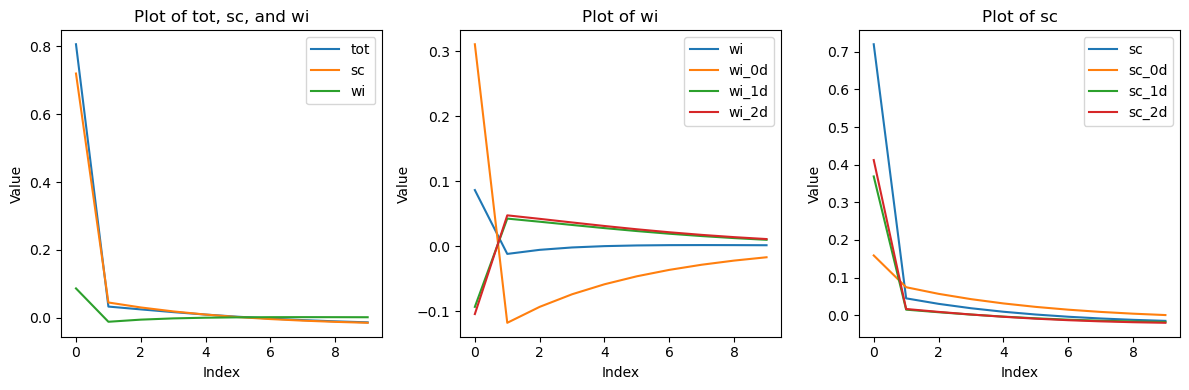

In [23]:
# Create a figure and two subplots in the same row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot tot, sc, and wi on the first subplot
ax1.plot(tot[0:10], label='tot')
ax1.plot(sc[0:10], label='sc')
ax1.plot(wi[0:10], label='wi')
ax1.legend()
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')
ax1.set_title('Plot of tot, sc, and wi')

# Plot only wi on the second subplot
ax2.plot(wi[0:10], label='wi')
ax2.plot(wi_0d[0:10], label='wi_0d')
ax2.plot(wi_1d[0:10], label='wi_1d')
ax2.plot(wi_2d[0:10], label='wi_2d')
ax2.legend()
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')
ax2.set_title('Plot of wi')

ax3.plot(sc[0:10], label='sc')
ax3.plot(sc_0d[0:10], label='sc_0d')
ax3.plot(sc_1d[0:10], label='sc_1d')
ax3.plot(sc_2d[0:10], label='sc_2d')
ax3.legend()
ax3.set_xlabel('Index')
ax3.set_ylabel('Value')
ax3.set_title('Plot of sc')

# Show the plot
plt.tight_layout()
plt.show()

In [24]:
j

0

In [25]:
np.mean(np.exp(t[j].endo_simul[2]))
n_0=np.insert(t[j].ir_level.n_0_a_0,0,np.exp(t[j].steady_state[0]))

In [26]:

n_0=np.exp(t[j].endo_simul[0])
n_1=np.exp(t[j].endo_simul[1])
n_2=np.exp(t[j].endo_simul[2])
s_0=np.exp(t[j].endo_simul[3])
s_1=np.exp(t[j].endo_simul[4])
s_2=np.exp(t[j].endo_simul[5])
k=t[j].endo_simul[6]
c_0=t[j].endo_simul[7]
c_1=t[j].endo_simul[8]
c_2=t[j].endo_simul[9]
i=t[j].endo_simul[10]
a_0=t[j].endo_simul[11]
a_1=t[j].endo_simul[12]
a_2=t[j].endo_simul[13]


#i=np.log(t[j].endo_simul[10])

#i
print(np.exp(np.mean(n_0)))
print(np.exp(t[j].steady_state[0][0]))
print(np.mean(n_0))
print((t[j].steady_state[0][0]))
ss=t[j].steady_state[0][0]
n_0try=np.exp(n_0)
(np.mean(n_0try))
(n_0[0] + n_1[0] + n_2[0])[100:]
print(np.mean(xx))
print(np.mean(s_0+s_2+s_1))

1.779938343843829
0.26630527739373694
0.5765787254140906
-1.3231119688830717


IndexError: invalid index to scalar variable.

In [ ]:
np.mean(np.exp(n_0+np.mean(n_0)))

In [ ]:
np.mean(np.exp(n_0+np.exp(np.mean(n_0))))

In [ ]:

n_0=t[j].endo_simul[0]
n_1=np.exp(t[j].endo_simul[1])*np.exp(t[j].steady_state[1])
n_2=np.exp(t[j].endo_simul[2])*np.exp(t[j].steady_state[2])
s_0=t[j].endo_simul[3]
s_1=t[j].endo_simul[4]    
s_2=t[j].endo_simul[5]
k=t[j].endo_simul[6]
c_0=t[j].endo_simul[7]
c_1=t[j].endo_simul[8]
c_2=t[j].endo_simul[9]
i=t[j].endo_simul[10]
a_0=t[j].endo_simul[11]
a_1=t[j].endo_simul[12]
a_2=t[j].endo_simul[13]


#i=np.log(t[j].endo_simul[10])

#i
print(np.exp(np.mean(n_0)))
print(np.exp(t[j].steady_state[0][0]))
print(np.mean(n_0))
print((t[j].steady_state[0][0]))



In [ ]:
n_0+n_1+n_2

In [ ]:
np.exp(t[j].steady_state[0])

In [ ]:
mean_exp = np.mean(np.exp(n_0+.28))
print(mean_exp)

In [ ]:
p_0=om_0/om_0*(c_0/c_0)**(-1/eps)
p_1=om_1/om_0*(c_1/c_0)**(-1/eps)
p_2=om_2/om_0*(c_2/c_0)**(-1/eps)
y_0=c_0+i
py_0=p_0*y_0
py_1=p_1*c_1
py_2=p_2*c_2


y=py_0+py_1+py_2
r=1
ym=np.roll(y,1)
y_0m=np.roll(y,1)
n_0m=np.roll(n_0,1)
n_1m=np.roll(n_1,1)
n_2m=np.roll(n_2,1)
py_0m=np.roll(py_0,1)
py_1m=np.roll(py_1,1)
py_2m=np.roll(py_2,1)

tot=(1/r*y-ym)/ym

sc=(
(1/r*py_0/n_0-py_0m/n_0m)*n_0+
(1/r*py_1/n_1-py_1m/n_1m)*n_1+
(1/r*py_2/n_2-py_2m/n_2m)*n_2
)/ym

wi=(
(n_0-n_0m)*py_0m/n_0m+
(n_1-n_1m)*py_1m/n_1m+
(n_2-n_2m)*py_2m/n_2m
)/ym

wi_0d=((n_0-n_0m)/n_0m*py_0m)
wi_1d=((n_1-n_1m)/n_1m*py_1m)
wi_2d=((n_2-n_2m)/n_2m*py_2m)

sc_0d=((1/r*py_0/n_0-py_0m/n_0m)*n_0)
sc_1d=((1/r*py_1/n_1-py_1m/n_1m)*n_1)
sc_2d=((1/r*py_2/n_2-py_2m/n_2m)*n_2)



In [ ]:
df = pd.DataFrame({
    'py_0': py_0,
    'py_1': py_1,
    'py_2': py_2m
})

In [ ]:
# Calculate the variance-covariance matrix
df_cov = df.cov()


In [ ]:
p

In [ ]:

# Function to highlight the diagonal
def highlight_diagonal(data):
	attr = 'background-color: yellow'
	# Create a DataFrame with empty strings
	df_styler = pd.DataFrame('', index=data.index, columns=data.columns)
	# Set the diagonal to the desired attribute
	np.fill_diagonal(df_styler.values, attr)
	return df_styler

# Apply the function to the DataFrame
styled_df_cov = df_cov.style.apply(highlight_diagonal, axis=None)

# Display the styled DataFrame
styled_df_cov

In [ ]:
import pandas as pd
from IPython.display import display

# Define a function to highlight the 'win' column in light blue
def highlight_win_column(x):
	df = pd.DataFrame('', index=x.index, columns=x.columns)
	if 'win' in df.columns:
		df['win'] = 'background-color: lightblue'
	

	return df

# Define a function to highlight the diagonal in yellow
def highlight_diagonal(x):
	df = pd.DataFrame('', index=x.index, columns=x.columns)
	for i in range(len(df)):
		df.iat[i, i] = 'background-color: yellow'
  
  
  
	return df

# Iterate through the list and process each element
for i in range(len(t)):
	data = t[i].var

	# Convert to DataFrame
	df = pd.DataFrame(data)

	# Set the index and columns names from ss_dict
	df.index = ss_dict.keys()
	df.columns = ss_dict.keys()

	# Apply the highlighting functions to the DataFrame and round to three digits
	styled_df = df.style.apply(highlight_win_column, axis=None).apply(highlight_diagonal, axis=None).format(precision=3)
	
	# Set smaller font size
	styled_df = styled_df.set_table_styles([{
		'selector': 'table',
		'props': [('font-size', '6pt')]
	}])
	
	# Display the styled DataFrame
	display(styled_df)

In [ ]:
Mthing.endo_names